In [1]:
import pandas as pd
import numpy as np
import numpy as np
from scipy.stats import rankdata
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
df = pd.read_csv('sddt_links.tsv', sep='\t')

# Convert the 'drug_name' and 'disease_term' columns to lowercase
df['drug_name'] = df['drug_name'].str.lower()
df['doid'] = df['doid'].str.lower()

# Read the 'aact_study_refs.tsv' file into a DataFrame
aact_study_refs_df = pd.read_csv('aact_study_refs.tsv', sep='\t')
# Print the row with 'nct_id' equal to 'NCT00157716'
aact_study_refs_df[aact_study_refs_df['nct_id'] == 'NCT00655655']

,id,nct_id,reference_type,pmid,citation


How many drugs, diseases, and genes do we have in this data-set?

In [2]:
# Count unique drugs, diseases, and genes
unique_drugs = df['drug_name'].nunique()
unique_diseases = df['doid'].nunique()
unique_genes = df['gene_symbol'].nunique()

print(f"Number of unique drugs: {unique_drugs}")
print(f"Number of unique doid: {unique_diseases}")
print(f"Number of unique genes: {unique_genes}")

Number of unique drugs: 224
Number of unique doid: 585
Number of unique genes: 790


In [3]:

# Group by disease_term and gene_symbol, then count unique drug_name
df2 = df.groupby(['doid', 'gene_symbol'])['drug_name'].nunique().reset_index()
# Rename the count column for clarity
df2 = df2.rename(columns={'drug_name': 'unique_drugs_count'})


#have to have the disease-target in df data frame
df['disease-target'] = df['doid'] + '-' + df['gene_symbol']

#have to have the disease-target in df data frame
df2['disease-target'] = df['doid'] + '-' + df['gene_symbol']

# Assuming you have a DataFrame df2 with a 'disease-target' column
association_counts = df['disease-target'].value_counts()

# Get the number of unique associations
unique_associations = len(association_counts)

# Get the association with the highest frequency
highest_frequency_association = association_counts.idxmax()
highest_frequency = association_counts.max()

print(f"Number of unique associations: {unique_associations}")
print(f"Association with the highest frequency: {highest_frequency_association} (Frequency: {highest_frequency})")

Number of unique associations: 75821
Association with the highest frequency: doid:10763-CYP2D6 (Frequency: 476)


In [4]:
# association counts from 'disease-target' column
association_counts = df['disease-target'].value_counts()
# Get the total number of associations
total_associations = len(df)
# Get the number of unique associations
unique_associations = len(association_counts)
# Get the association with the highest frequency
highest_frequency_association = association_counts.idxmax()
highest_frequency = association_counts.max()

print(f"Total number of associations: {total_associations}")
print(f"Number of unique associations: {unique_associations}")
print(f"Association with the highest frequency: {highest_frequency_association} (Frequency: {highest_frequency})")

Total number of associations: 422552
Number of unique associations: 75821
Association with the highest frequency: doid:10763-CYP2D6 (Frequency: 476)


In [5]:

df2['nStudy'] = df.groupby('disease-target')['nct_id'].transform('nunique').fillna(0).astype(int)
association = "doid:10763-CYP2D6"

# Filter the DataFrame to get drugs associated with the specified association
associated_drugs = df[df['disease-target'] == association]['drug_name'].unique()

# Print the associated drugs
print(f"Drugs associated with {association}:")
for drug in associated_drugs:
    print(drug)

Drugs associated with doid:10763-CYP2D6:
candesartan
hydrochlorothiazide
chlorthalidone
azilsartan medoxomil
angiotensin ii
amiloride
amiloride hydrochloride
valsartan
chlortalidone
potassium chloride
progesterone
carbidopa
levodopa
fenofibrate
simvastatin
ezetimibe
acetyl-l-carnitine
enalapril
benazepril
fluvastatin
pitavastatin
sacubitril
nebivolol
telmisartan
ramipril
hctz
bisoprolol
amlodipine
indapamide
diclofenac sodium


In [6]:
# Define the constants
half_life_age = 5  # Half-life age in years
n_study = df2['nStudy']  #'nStudy' is the column with the total number of studies
# Calculate nStudy_Weighted using the formula
df2['nStudy_Weighted'] = n_study.apply(lambda x: sum([2**(-a/half_life_age) for a in range(x)]))
aact_study_refs = pd.read_csv('aact_study_refs.tsv', sep='\t')
# Merge the two DataFrames on 'nct_id'
merged_df = df.merge(aact_study_refs[['nct_id', 'reference_type']], on='nct_id', how='left')
# Merge the two DataFrames on 'nct_id'
merged_df = df.merge(aact_study_refs[['nct_id', 'reference_type', 'pmid']], on='nct_id', how='left')

# Filter rows where both 'reference_type' and 'pmid' are not null
filtered_df = merged_df.dropna(subset=['reference_type', 'pmid'])

# Count the number of rows in the filtered DataFrame
count = len(filtered_df)

# Print the count
print(f'Number of disease-target associations with reference type and publication ID: {count}')

Number of disease-target associations with reference type and publication ID: 1537309


In [7]:
# 'disease-target' column and merged_df with a 'disease-target' and 'pmid' columns
df2['nPub'] = df2['disease-target'].map(merged_df.groupby('disease-target')['pmid'].nunique())

# If there are NaN values in the 'nPub' column, replace them with 0
df2['nPub'].fillna(0, inplace=True)

# group 'disease-target' column in df2 and merged_df with 'disease-target' and 'reference_type' columns
df2['publication_type'] = df2['disease-target'].map(merged_df.groupby('disease-target')['reference_type'].unique().str.join(', '))

# If there are NaN values in the 'publication_type' column, replace them with an empty string
df2['publication_type'].fillna('', inplace=True)
df2['publication_type'].nunique()

16

In [8]:
# Define a mapping of publication types to their corresponding values
publication_type_values = {
    'result': 0,
    'background': 1,
    'derived': 2
}

# Create a function to calculate the sum based on the mapping
def calculate_t_sum(publication_types):
    # Split the publication types string and filter out empty strings
    types = [type.strip() for type in publication_types.split(',') if type.strip()]
    
    # Calculate the sum of values based on the publication types
    return sum(publication_type_values.get(type.lower(), 0) for type in types)

# Apply the function to the 'publication_type' column and create the 't_sum' column
df2['t_sum'] = df2['publication_type'].apply(calculate_t_sum)

# Find the row with the maximum t_sum value
max_t_sum_row = df2[df2['t_sum'] == df2['t_sum'].max()]

In [9]:
# Calculate nPub_Weighted
df2['nPub_Weighted'] = np.exp(2 * df2['t_sum'])
# Calculate nDiseaseMention
df2['nDiseaseMention'] = df2.groupby('disease-target')['doid'].transform('count')
# Find the row with the maximum disease mention value
max_nDiseaseMention = df2[df2['nDiseaseMention'] == df2['nDiseaseMention'].max()]
# Find the row with the maximum disease mention value
max_unique_drugs_count = df2[df2['unique_drugs_count'] == df2['unique_drugs_count'].max()]
df2['nDrugMention'] = df2['unique_drugs_count'].copy()

# Define the columns you want to read
columns_to_read = ['pchembl_value', 'target_chembl_id', 'molecule_chembl_id']

# Read the CSV file with selected columns
pchembl_df = pd.read_csv("aact_drugs_chembl_activity.tsv", sep="\t", usecols=columns_to_read)

df2['Rank'] = df2[['nStudy_Weighted', 'nPub_Weighted', 'nDiseaseMention', 'nDrugMention']].rank(ascending=False).sum(axis=1)
sorted_df = df2.sort_values(by='Rank')

Here is what is ahppening in the next cell

Rank Calculation:
        The code calculates ranks for four columns: nStudy_Weighted, nPub_Weighted, nDiseaseMention, and nDrugMention using the rankdata function from the SciPy library.
        The rankdata function assigns a rank to each element in a column based on its value. It returns an array of ranks for the elements in the specified column.

    Weight Calculation Function:
        A custom function called calculate_weight is defined. This function calculates weights based on the values in the nPub column. The weight calculation is done based on a simple linear mapping.

    Weight Assignment:
        The weight function is applied to the nPub column using the apply method. This calculates weights for each value in the nPub column based on the custom weight calculation function.
        The calculated weights are then stored in a new column called nPub_weight.

In summary, the code assigns ranks to specific columns and calculates weights for the nPub column based on a custom weight calculation function. This can be useful for assigning relative importance or weights to different columns in your DataFrame based on certain criteria.

In [10]:


# Calculate ranks for each column using rankdata function from scipy
df2['rank_nStudy_Weighted'] = rankdata(df2['nStudy_Weighted'])
df2['rank_nPub_Weighted'] = rankdata(df2['nPub_Weighted'])
df2['rank_nDiseaseMention'] = rankdata(df2['nDiseaseMention'])
df2['rank_nDrugMention'] = rankdata(df2['nDrugMention'])

# Define a weight function based on nPub values
def calculate_weight(nPub_value):
    # You can adjust this function as needed to determine the weight based on nPub
    # In this example, we'll use a simple linear mapping from nPub to weight.
    min_nPub = df2['nPub'].min()
    max_nPub = df2['nPub'].max()
    return (nPub_value - min_nPub) / (max_nPub - min_nPub)

# Apply the weight function to the 'nPub' column to create a weight column
df2['nPub_weight'] = df2['nPub'].apply(calculate_weight)
df2


,doid,gene_symbol,unique_drugs_count,disease-target,nStudy,nStudy_Weighted,nPub,publication_type,t_sum,nPub_Weighted,nDiseaseMention,nDrugMention,Rank,rank_nStudy_Weighted,rank_nPub_Weighted,rank_nDiseaseMention,rank_nDrugMention,nPub_weight
0,doid:0001816,ABCB11,1,doid:6713-KDM4E,22,7.359119,42,,0,1.000000,38,1,143720.0,51980.5,34202.0,51804.5,21581.0,0.053435
1,doid:0001816,ABCC2,1,doid:3393-KDM4E,11,6.043768,57,,0,1.000000,16,1,170182.5,39379.0,34202.0,37943.5,21581.0,0.072519
2,doid:0001816,ABCC3,1,doid:326-KDM4E,7,4.797787,24,,0,1.000000,8,1,189338.0,31943.5,34202.0,26223.5,21581.0,0.030534
3,doid:0001816,ABCC4,1,doid:8805-KDM4E,4,3.288163,5,,0,1.000000,4,1,206005.5,24329.0,34202.0,17170.5,21581.0,0.006361
4,doid:0001816,ACHE,1,doid:5844-KDM4E,11,6.043768,60,,0,1.000000,15,1,171434.5,39379.0,34202.0,36691.5,21581.0,0.076336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75816,doid:9993,USP1,3,doid:4195-HSP90AA1,1,1.000000,3,background,1,7.389056,1,3,166077.5,4838.5,69769.5,3055.0,59547.5,0.003817
75817,doid:9993,USP2,1,doid:1508-HSP90AA1,14,6.615809,14,,0,1.000000,18,1,162278.0,44695.5,34202.0,40531.5,21581.0,0.017812
75818,doid:9993,VCP,1,doid:9577-HSP90AA1,1,1.000000,0,,0,1.000000,1,1,239611.5,4838.5,34202.0,3055.0,21581.0,0.000000
75819,doid:9993,VDR,1,doid:2272-HSP90AA1,10,5.793768,5,,0,1.000000,15,1,173202.5,37611.0,34202.0,36691.5,21581.0,0.006361


In the next cell, here is what is going on - 

This code calculates the mean rank score for each row in a DataFrame (df2) based on a set of columns and the percentile formula. Here's a step-by-step explanation:

    Column Selection:
        It starts by defining a list of columns (mean_rank_columns) that will be used to calculate the mean rank. These columns are 'rank_nStudy_Weighted', 'rank_nPub_Weighted', 'rank_nDiseaseMention', 'rank_nDrugMention', and 'nPub_weight'.

    Calculating Mean Rank:
        The code calculates the mean rank for each row by taking the mean (average) of the values in the selected columns using the .mean(axis=1) method. This is done for every row in the DataFrame.

    Percentile Calculation:
        The percentile of the mean rank is calculated using the percentile formula. It calculates how the mean rank of each row compares to the range of mean ranks in the DataFrame.
        The formula (1 - (df2['mean_rank'] - df2['mean_rank'].min()) / (df2['mean_rank'].max() - df2['mean_rank'].min())) * 100 is used for this calculation. It normalizes the mean rank values to a 0-100 scale.
        The result is assigned to a new column in the DataFrame called 'mean_rank_score'.

    Displaying Results:
        The code displays a subset of columns from the DataFrame, specifically the 'disease-target' and 'mean_rank_score' columns.

In summary, this code calculates a mean rank score for each row in the DataFrame based on a set of columns and then converts these mean rank scores into a percentile-based score. The resulting scores can provide a relative ranking of rows based on their mean ranks, with higher scores indicating higher relative ranks.

i removed 'rank_nPub_Weighted',

In [11]:
# Define the list of columns to calculate the mean rank
mean_rank_columns = ['rank_nStudy_Weighted', 'rank_nDiseaseMention', 'rank_nDrugMention', 'nPub_weight']

# Calculate the mean rank score for each row
df2['mean_rank'] = df2[mean_rank_columns].mean(axis=1)

# Calculate the mean rank score using the percentile formula
percentile = (1 - (df2['mean_rank'] - df2['mean_rank'].max()) / (df2['mean_rank'].min() - df2['mean_rank'].max())) * 100

# Calculate the mean rank score
df2['mean_rank_score'] = percentile

# Display the relevant columns
df2[['disease-target', 'mean_rank_score']]

,disease-target,mean_rank_score
0,doid:6713-KDM4E,48.544697
1,doid:3393-KDM4E,35.148177
2,doid:326-KDM4E,25.450764
3,doid:8805-KDM4E,17.012900
4,doid:5844-KDM4E,34.514359
...,...,...
75816,doid:4195-HSP90AA1,19.220383
75817,doid:1508-HSP90AA1,39.149769
75818,doid:9577-HSP90AA1,0.000000
75819,doid:2272-HSP90AA1,33.619281


Another way of calculating the weights above - 

Define a weight function based on nPub values

def calculate_weight(nPub_value):
    # You can adjust this function as needed to determine the weight based on nPub
    return nPub_value / 810  # 800 is the maximum value of nPub, adjust accordingly

Apply the weight function to the 'nPub' column to create a weight column

df2['nPub_weight'] = df2['nPub'].apply(calculate_weight)
df2

In [12]:
# Read the 'tcrd_targets.tsv' file into a DataFrame
doid_df = pd.read_csv('doid.tsv', sep='\t')
# Convert the 'doid' column in 'df' to lowercase
df['doid'] = df['doid'].str.lower()

# Convert the 'id' column in 'doid_df' to lowercase
doid_df['id'] = doid_df['id'].str.lower()

# Merge 'df' with 'doid_df' on the lowercase 'doid' and 'id' columns
df2 = df2.merge(doid_df[['id', 'name']], 
              left_on='doid', right_on='id', 
              how='left')

# Drop the duplicate 'id' column
df2.drop(columns=['id'], inplace=True)

# Rename the 'name' column to 'disease_name'
df2.rename(columns={'name': 'disease_name'}, inplace=True)

 Add'tcrdTargetName' column from 'tcrd_df' to 'df2'

In [13]:
tcrd_df = pd.read_csv('tcrd_targets.tsv', sep='\t')
# Merge df2 with tcrd_df on 'gene_symbol' and 'tcrdGeneSymbol' columns
merged_df = df2.merge(tcrd_df[['tcrdGeneSymbol', 'tcrdTargetName']], 
                      left_on='gene_symbol', right_on='tcrdGeneSymbol', 
                      how='left')

# Drop the duplicate 'tcrdGeneSymbol' column
merged_df.drop(columns=['tcrdGeneSymbol'], inplace=True)

# Rename the 'tcrdTargetName' column to 'tcrdTargetName_df2'
merged_df.rename(columns={'tcrdTargetName': 'tcrdTargetName'}, inplace=True)

# Reorder the columns
merged_df = merged_df[['disease_name', 'tcrdTargetName'] + [col for col in merged_df.columns if col not in ['disease_name', 'tcrdTargetName']]]

merged_df

,disease_name,tcrdTargetName,doid,gene_symbol,unique_drugs_count,disease-target,nStudy,nStudy_Weighted,nPub,publication_type,...,nDiseaseMention,nDrugMention,Rank,rank_nStudy_Weighted,rank_nPub_Weighted,rank_nDiseaseMention,rank_nDrugMention,nPub_weight,mean_rank,mean_rank_score
0,angiosarcoma,Bile salt export pump,doid:0001816,ABCB11,1,doid:6713-KDM4E,22,7.359119,42,,...,38,1,143720.0,51980.5,34202.0,51804.5,21581.0,0.053435,31341.513359,48.544697
1,angiosarcoma,Canalicular multispecific organic anion transp...,doid:0001816,ABCC2,1,doid:3393-KDM4E,11,6.043768,57,,...,16,1,170182.5,39379.0,34202.0,37943.5,21581.0,0.072519,24725.893130,35.148177
2,angiosarcoma,Canalicular multispecific organic anion transp...,doid:0001816,ABCC3,1,doid:326-KDM4E,7,4.797787,24,,...,8,1,189338.0,31943.5,34202.0,26223.5,21581.0,0.030534,19937.007634,25.450764
3,angiosarcoma,Multidrug resistance-associated protein 4,doid:0001816,ABCC4,1,doid:8805-KDM4E,4,3.288163,5,,...,4,1,206005.5,24329.0,34202.0,17170.5,21581.0,0.006361,15770.126590,17.012900
4,angiosarcoma,Acetylcholinesterase,doid:0001816,ACHE,1,doid:5844-KDM4E,11,6.043768,60,,...,15,1,171434.5,39379.0,34202.0,36691.5,21581.0,0.076336,24412.894084,34.514359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81816,hypoglycemia,Ubiquitin carboxyl-terminal hydrolase 1,doid:9993,USP1,3,doid:4195-HSP90AA1,1,1.000000,3,background,...,1,3,166077.5,4838.5,69769.5,3055.0,59547.5,0.003817,16860.250954,19.220383
81817,hypoglycemia,Ubiquitin carboxyl-terminal hydrolase 2,doid:9993,USP2,1,doid:1508-HSP90AA1,14,6.615809,14,,...,18,1,162278.0,44695.5,34202.0,40531.5,21581.0,0.017812,26702.004453,39.149769
81818,hypoglycemia,Transitional endoplasmic reticulum ATPase,doid:9993,VCP,1,doid:9577-HSP90AA1,1,1.000000,0,,...,1,1,239611.5,4838.5,34202.0,3055.0,21581.0,0.000000,7368.625000,0.000000
81819,hypoglycemia,Vitamin D3 receptor,doid:9993,VDR,1,doid:2272-HSP90AA1,10,5.793768,5,,...,15,1,173202.5,37611.0,34202.0,36691.5,21581.0,0.006361,23970.876590,33.619281


In [16]:
# Display instances with a mean rank score of 100
instances_with_mean_rank_100 = merged_df[merged_df['mean_rank_score'] == 100]
instances_with_mean_rank_100.to_csv('test', index = False)

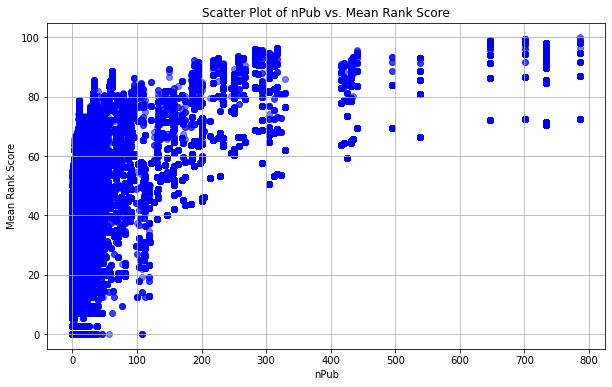

In [15]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df2['nPub'], df2['mean_rank_score'], alpha=0.5, color='b')
plt.title('Scatter Plot of nPub vs. Mean Rank Score')
plt.xlabel('nPub')
plt.ylabel('Mean Rank Score')
plt.grid(True)
plt.show()

In [17]:
# Display instances with a mean rank score between 70 and 100
instances_with_mean_rank_70_100 = merged_df[(merged_df['mean_rank_score'] >= 70) & (merged_df['mean_rank_score'] <= 100)]

# Save the selected instances to a CSV file
instances_with_mean_rank_70_100.to_csv('instances_with_mean_rank_70_100.csv', index=False)

In [18]:
# Specify the columns for which you want to find the disease target with the highest values
columns_to_max = ['nStudy', 'nStudy_Weighted', 'nPub', 'publication_type', 't_sum', 'nPub_Weighted', 'nDiseaseMention', 'nDrugMention']

# Create an empty dictionary to store the disease targets with the highest values
highest_values = {}

# Iterate through each column and find the disease target with the highest value
for column in columns_to_max:
    # Convert the column to a numeric data type (assuming it's not already numeric)
    sorted_df[column] = pd.to_numeric(sorted_df[column], errors='coerce')
    
    # Check for missing values (nan)
    if sorted_df[column].isna().all():
        highest_values[column] = None
    else:
        # Find the index of the maximum value in the column, excluding nan values
        max_index = sorted_df[column].idxmax(skipna=True)
        
        # Get the disease target corresponding to the maximum value
        disease_target = sorted_df.loc[max_index, 'disease-target']
        
        # Store the disease target in the dictionary
        highest_values[column] = disease_target

# Display the disease targets with the highest values for each column
for column, disease_target in highest_values.items():
    print(f"{column}: {disease_target}")

nStudy: doid:10763-CYP1A2
nStudy_Weighted: doid:10763-CYP1A2
nPub: doid:10763-CYP1A2
publication_type: None
t_sum: doid:12365-ABCB11
nPub_Weighted: doid:12365-ABCB11
nDiseaseMention: doid:10763-CYP1A2
nDrugMention: doid:0081062-BRD4


In [19]:
min_nPub = df2['nPub'].min()
max_nPub = df2['nPub'].max()

print("Minimum nPub:", min_nPub)
print("Maximum nPub:", max_nPub)

Minimum nPub: 0
Maximum nPub: 786


In [21]:
# Create a new column that represents nPub ranges
df2['nPub_Range'] = pd.cut(df2['nPub'], bins=[0, 99, 199, 299, 399, 499, 599, 699, 799, 899])

# Get the value counts for each nPub range
nPub_range_counts = df2['nPub_Range'].value_counts().sort_index()

# Print the counts for each nPub range
for nPub_range, count in nPub_range_counts.iteritems():
    print(f'nPub Range: {nPub_range}, Counts: {count}')

nPub Range: (0, 99], Counts: 50695
nPub Range: (99, 199], Counts: 5338
nPub Range: (199, 299], Counts: 4439
nPub Range: (299, 399], Counts: 2040
nPub Range: (399, 499], Counts: 1703
nPub Range: (499, 599], Counts: 116
nPub Range: (599, 699], Counts: 440
nPub Range: (699, 799], Counts: 2612
nPub Range: (799, 899], Counts: 0


/tmp/ipykernel_128754/2017513589.py:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for nPub_range, count in nPub_range_counts.iteritems():


In [22]:
merged_df.to_csv('tictac_genes_disease_associations2.csv', index = False)

In [23]:
merged_df.columns

Index(['disease_name', 'tcrdTargetName', 'doid', 'gene_symbol',
       'unique_drugs_count', 'disease-target', 'nStudy', 'nStudy_Weighted',
       'nPub', 'publication_type', 't_sum', 'nPub_Weighted', 'nDiseaseMention',
       'nDrugMention', 'Rank', 'rank_nStudy_Weighted', 'rank_nPub_Weighted',
       'rank_nDiseaseMention', 'rank_nDrugMention', 'nPub_weight', 'mean_rank',
       'mean_rank_score'],
      dtype='object')

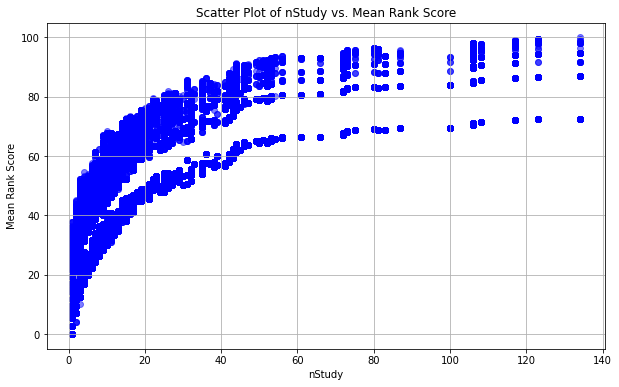

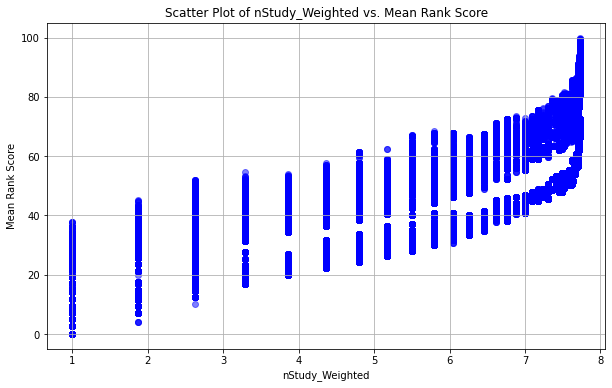

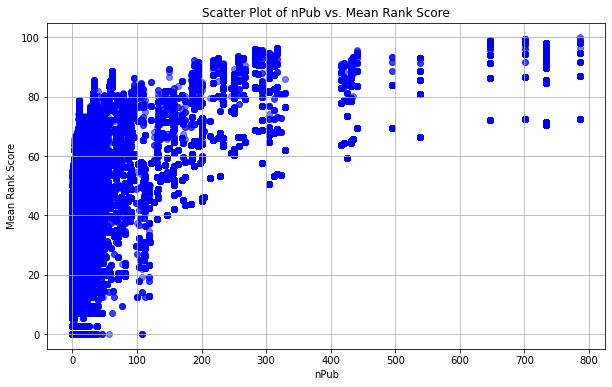

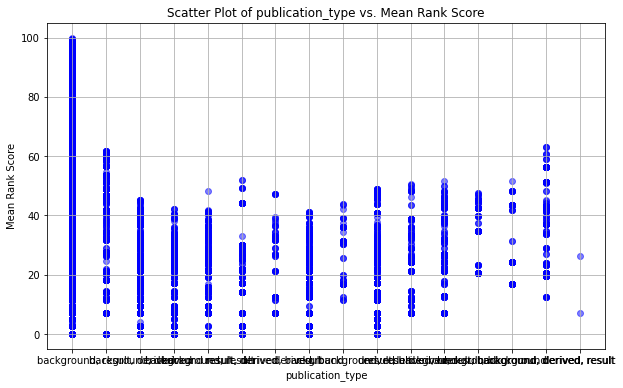

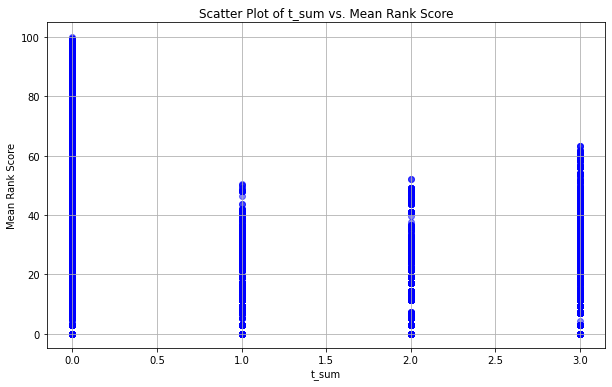

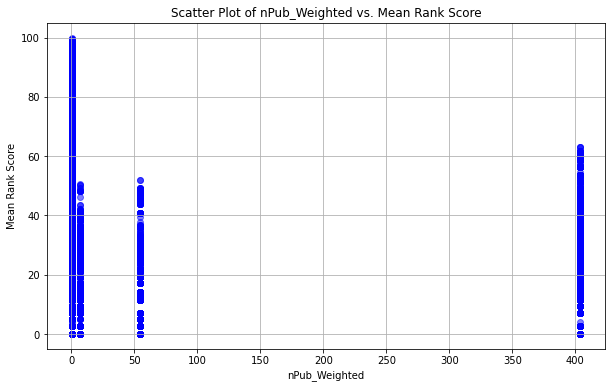

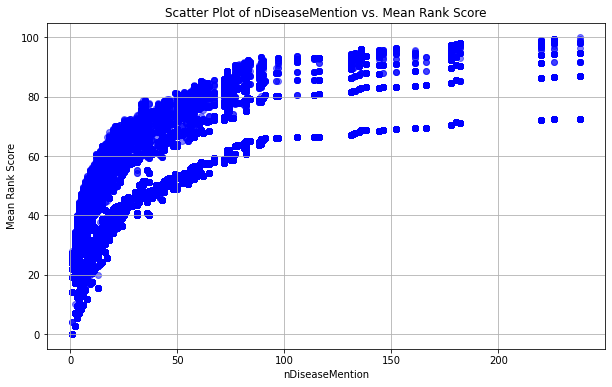

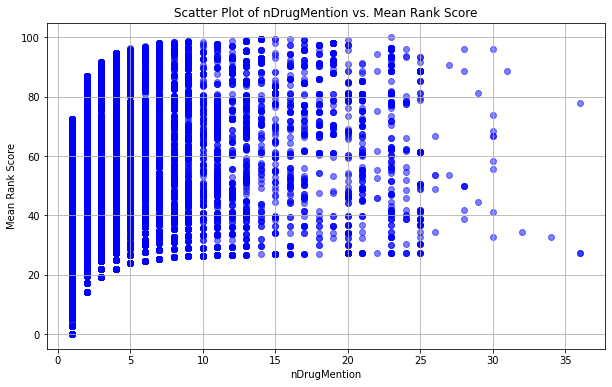

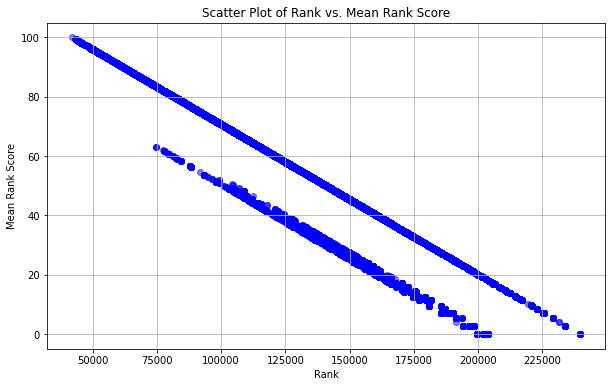

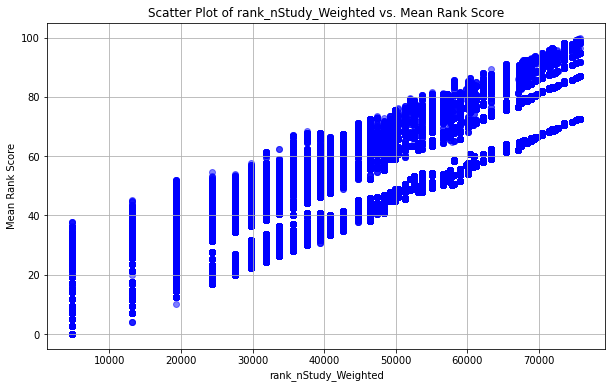

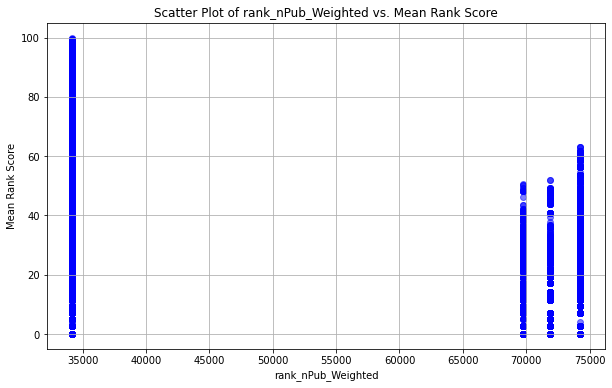

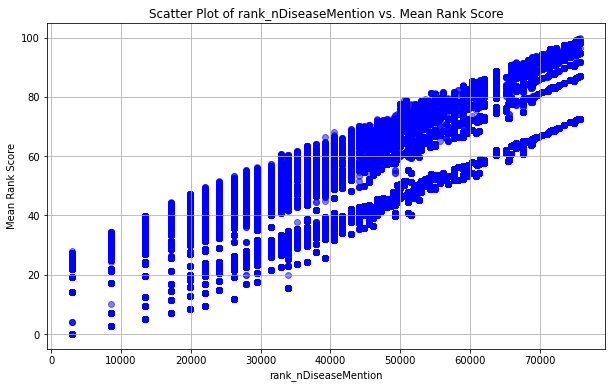

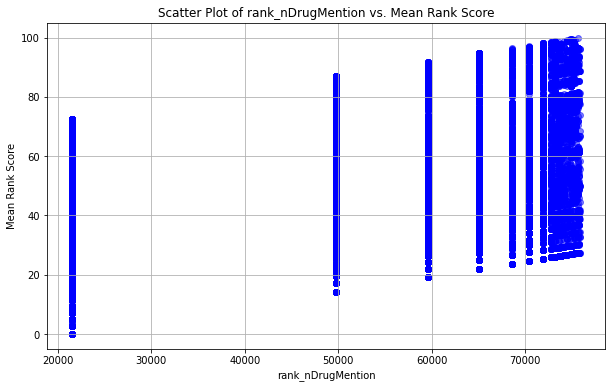

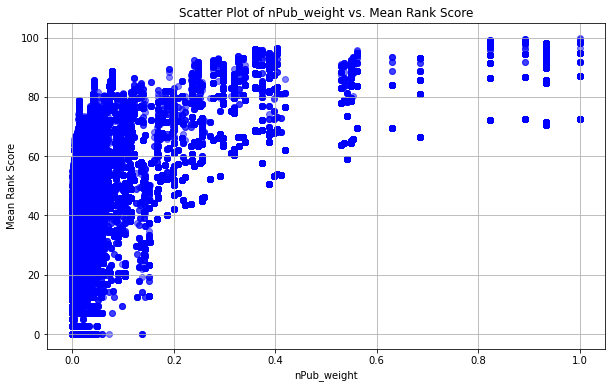

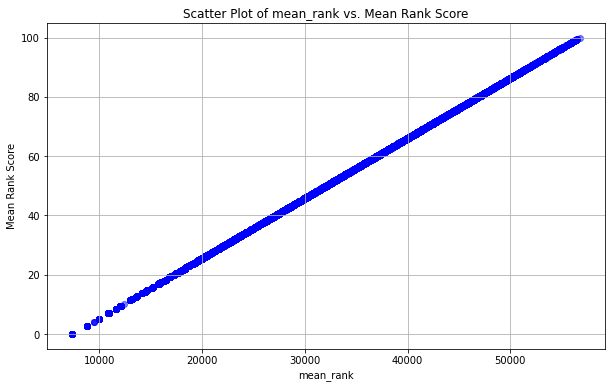

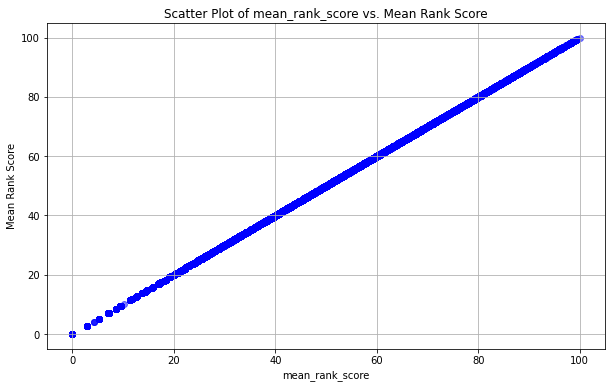

In [24]:
# List of columns to create scatter plots
columns_to_plot = ['nStudy', 'nStudy_Weighted', 'nPub', 'publication_type', 't_sum', 'nPub_Weighted',
                   'nDiseaseMention', 'nDrugMention', 'Rank', 'rank_nStudy_Weighted', 'rank_nPub_Weighted',
                   'rank_nDiseaseMention', 'rank_nDrugMention', 'nPub_weight', 'mean_rank', 'mean_rank_score']

# Scatter plots for each column against Mean Rank Score
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.scatter(df2[column], df2['mean_rank_score'], alpha=0.5, color='b')
    plt.title(f'Scatter Plot of {column} vs. Mean Rank Score')
    plt.xlabel(column)
    plt.ylabel('Mean Rank Score')
    plt.grid(True)
    plt.show()

Question

Referencing this equation, the half-life is typically 5 years. How was 5 years arrived at?

nStudy_weighted = ∑(i=1 to N_study) 2e^(-a_i/k)
Where -
      N_study is the total number of studies related to the disease-target association
      a_i: the age in years of the i-th study
      k: Half-life age (typically 5 years)